# SBB

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

## Import Data

In [2]:
df = pd.read_csv('data/zugzahlen.csv')
df.head(10)

PID  ISB  Strecke_Nummer  \
0   SBB_GESE_CHY  SBB               1   
1   SBB_GIBU_ROL  SBB               1   
2   SBB_MIES_TAN  SBB               1   
3    SBB_MOR_STJ  SBB               1   
4    SBB_PER_ALL  SBB               1   
5    SBB_PRN_GLA  SBB               1   
6   SBB_TUI_GDBE  SBB               1   
7     SBB_JON_SJ  SBB               2   
8  SBB_LABA_LAPR  SBB               2   
9     SBB_RUS_SY  SBB               3   

                                 Strecke_Bezeichnung Strecke_Art  \
0                         Genève Aéroport - Lausanne     STRECKE   
1                         Genève Aéroport - Lausanne     STRECKE   
2                         Genève Aéroport - Lausanne     STRECKE   
3                         Genève Aéroport - Lausanne     STRECKE   
4                         Genève Aéroport - Lausanne     STRECKE   
5                         Genève Aéroport - Lausanne     STRECKE   
6                         Genève Aéroport - Lausanne     STRECKE   
7  St-Jean / Furet - Lancy-Bâtie - Chêne-Bourg-Fr...     STRECKE   
8  St-Jean / Furet - Lancy-Bâtie - Chêne-Bourg-Fr...     STRECKE   
9                       La Plaine Frontière - Genève     STRECKE   

  BP_Von_Abschnitt BP_Von_Abschnitt_Bezeichnung BP_Bis_Abschnitt  \
0             GESE              Genève-Sécheron              CHY   
1             GIBU               Gilly-Bursinel              ROL   
2             MIES                         Mies              TAN   
3              MOR                       Morges              STJ   
4              PER                       Perroy              ALL   
5              PRN                     Prangins              GLA   
6              TUI                Les Tuileries             GDBE   
7              JON            Jonction (Genève)               SJ   
8             LABA            Lancy-Bâtie (bif)             LAPR   
9              RUS                       Russin               SY   

  BP_Bis_Abschnitt_Bezeichnung  Anzahl_Zuege  ... TU Nummer Bedienpunkt Cargo  \
0                     Chambésy        126307  ...        11              None   
1                        Rolle         97943  ...        11              None   
2                       Tannay        126101  ...        11              None   
3               Morges-St-Jean        121566  ...        11                 *   
4                      Allaman         98005  ...        11              None   
5                        Gland         98503  ...        11              None   
6             Genthod-Bellevue        126311  ...        11              None   
7                St-Jean (bif)         25814  ...        11                 *   
8             Lancy-Pont-Rouge         25795  ...        11              None   
9                      Satigny         40988  ...        11              None   

          land  Haltestelle  Gde Nummer  gdnr TU Abkuerzung  Tarifhaltestelle  \
0  Switzerland            *        6621  6621   SBB CFF FFS              None   
1  Switzerland         None        5852  5852   SBB CFF FFS              None   
2  Switzerland            *        5723  5723   SBB CFF FFS              None   
3  Switzerland            *        5642  5642   SBB CFF FFS              None   
4  Switzerland         None        5860  5860   SBB CFF FFS              None   
5  Switzerland         None        5725  5725   SBB CFF FFS              None   
6  Switzerland            *        6606  6606   SBB CFF FFS              None   
7  Switzerland         None        6621  6621   SBB CFF FFS              None   
8  Switzerland         None        6628  6628   SBB CFF FFS              None   
9  Switzerland            *        6637  6637   SBB CFF FFS              None   

                     geopos_von                    geopos_bis  
0  6.14454714955, 46.2224480511  6.14732717469, 46.2423883571  
1  6.30636755445, 46.4450640594   6.3364074853, 46.4627442908  
2  6.16956925257, 46.2998837999  6.18111951391, 46.3076442488  
3  6.49396657295, 46.51

In [3]:
df['lon_von'] = df.geopos_von.str.split('\,').str[0]
df['lon_von'] = df['lon_von'].map(float)

In [4]:
df['lat_von'] = df.geopos_von.str.split('\,').str[1]
df['lat_von'] = df['lat_von'].map(float)

In [5]:
df['lon_bis'] = df.geopos_bis.str.split('\,').str[0]
df['lon_bis'] = df['lon_bis'].map(float)

In [6]:
df['lat_bis'] = df.geopos_bis.str.split('\,').str[1]
df['lat_bis'] = df['lat_bis'].map(float)

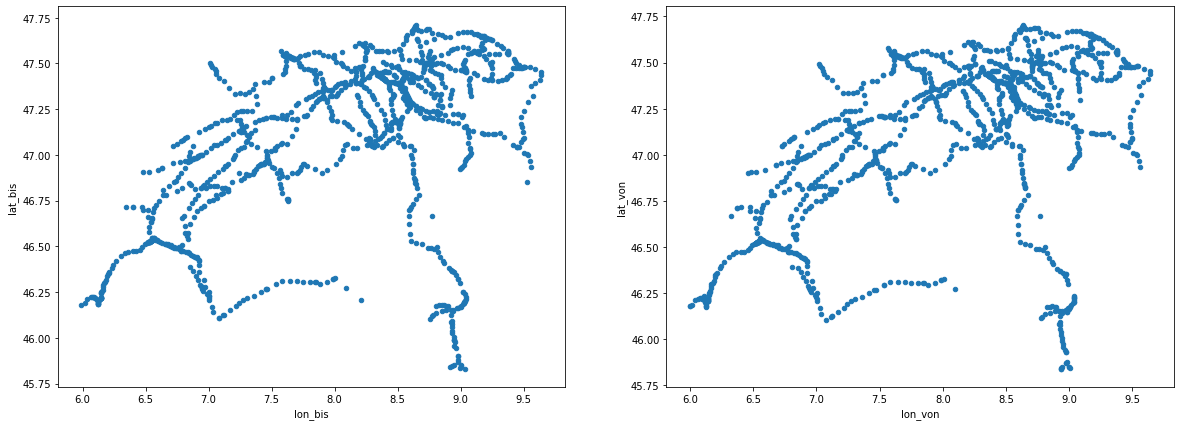

In [7]:
fig, axes = plt.subplots(figsize = (20,7), nrows=1, ncols=2);
df.plot.scatter(ax=axes[1], x='lon_von', y ='lat_von');
df.plot.scatter(ax=axes[0], x='lon_bis', y ='lat_bis');

In [8]:
pos_von = {}
for i in range(0, len(df)):
    pos_von[df.BP_Von_Abschnitt[i]] = (df.lon_von[i], df.lat_von[i])

In [9]:
pos_bis = {}
for i in range(0, len(df)):
    pos_bis[df.BP_Bis_Abschnitt[i]] = (df.lon_bis[i], df.lat_bis[i])

In [10]:
# Magic merge of dictionaries
pos = {**pos_bis, **pos_von}

In [11]:
df['weight'] = df['Anzahl_Zuege'].map(float)
df['weight'] /= np.max(df['weight'])

## Building the Network

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
D = nx.from_pandas_edgelist(df, source = 'BP_Von_Abschnitt', target = 'BP_Bis_Abschnitt',
                            edge_attr = 'weight', create_using = nx.DiGraph())

In [14]:
G = nx.Graph(D)

In [15]:
bond = np.array(list(nx.get_edge_attributes(G,'weight').values()))

In [16]:
# Calculate degree centrality,
eigenvector_centrality = nx.eigenvector_centrality(G)

# Set degree centrality metrics on each node,
nx.set_node_attributes(G, eigenvector_centrality, 'ec')

In [17]:
ec = np.array(list(nx.get_node_attributes(G,'ec').values()))

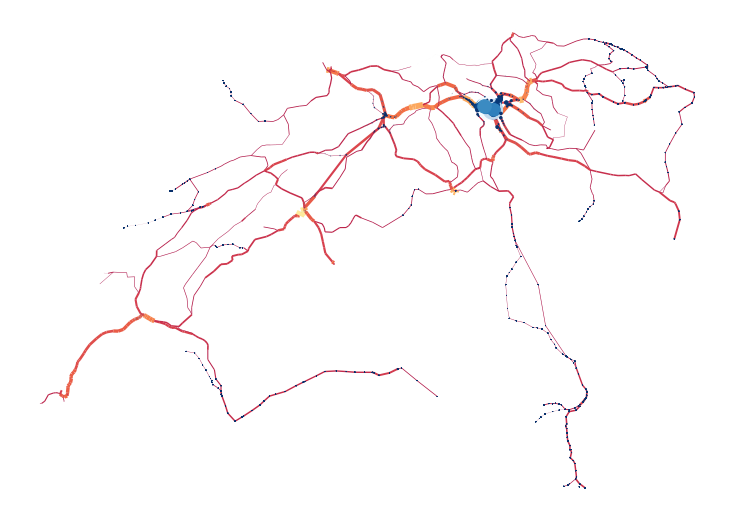

In [18]:
plt.figure(figsize = (10,7))
nx.draw(G, pos=pos, edge_color=bond, node_color=ec, with_labels=False, node_size=ec*1000,
        width=bond*20, edge_cmap=plt.cm.Spectral, cmap=plt.cm.Blues_r)

In [19]:
_pos = nx.spring_layout(G, seed=0)

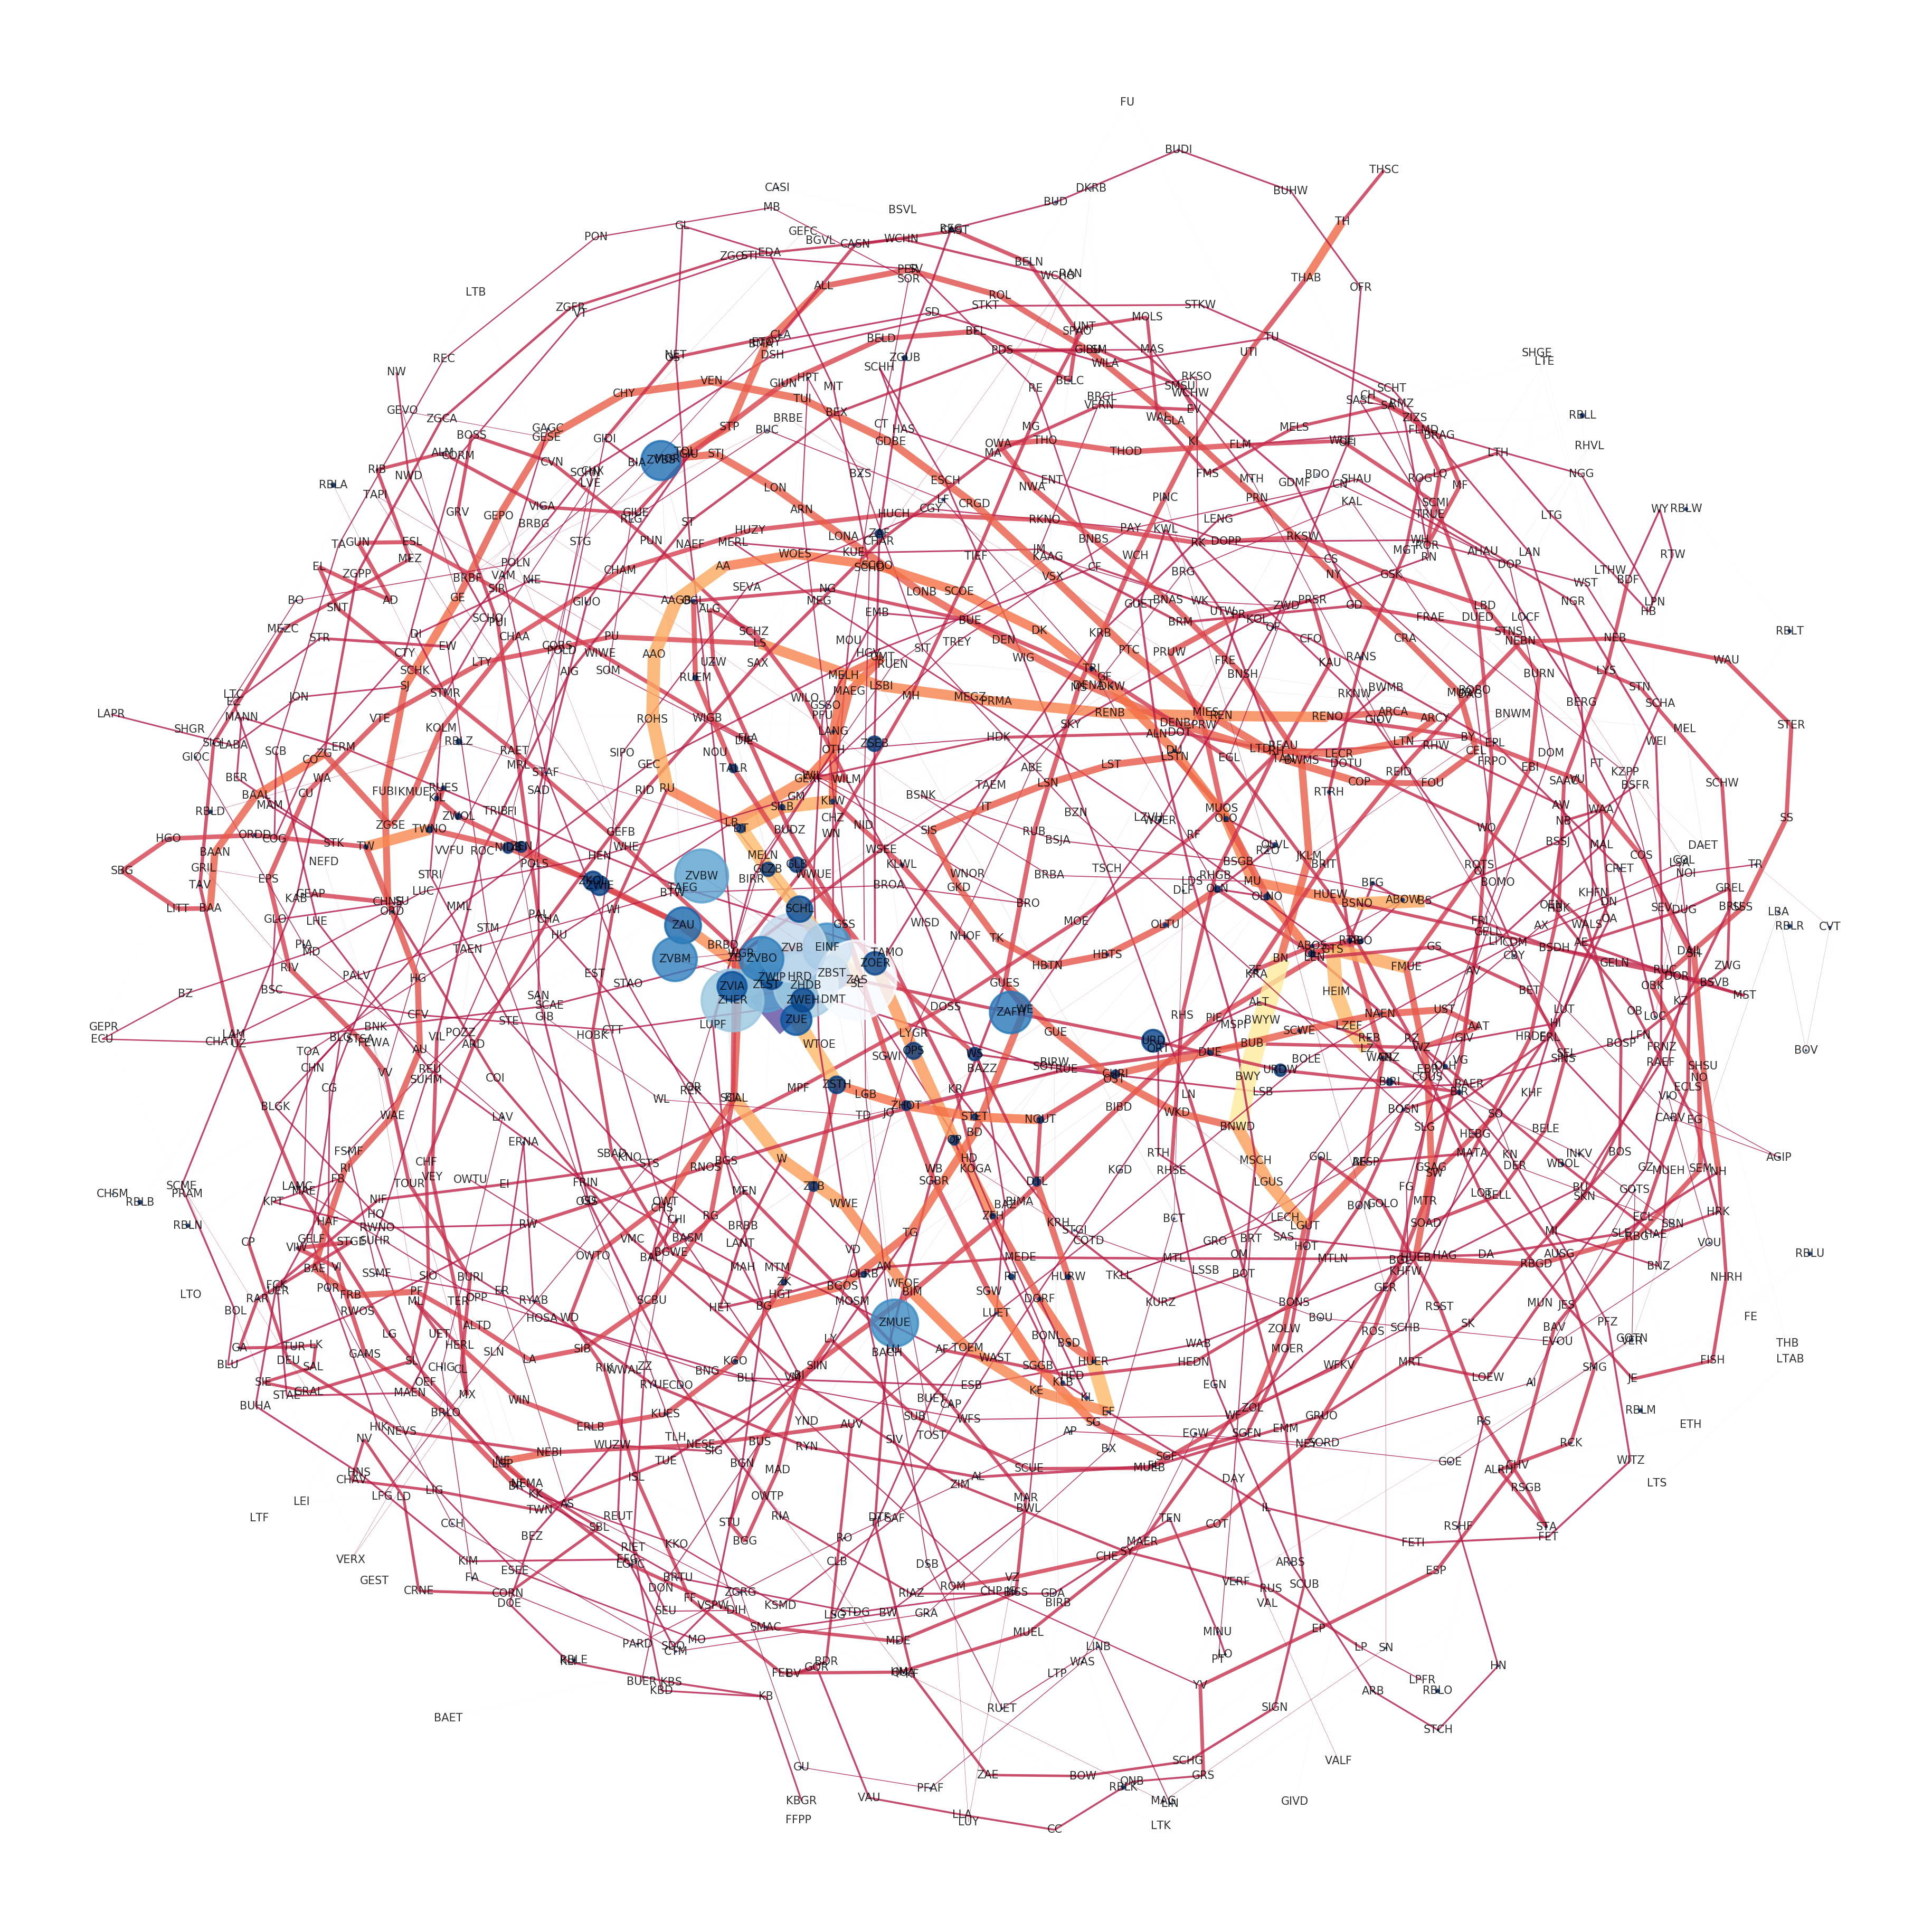

In [20]:
plt.figure(figsize = (12,12), dpi=300)
nx.draw(G, pos=_pos, edge_color=bond, node_color=ec, with_labels=True, font_size=5, weight='weight', node_size=ec*2500,
        width=bond*20, edge_cmap=plt.cm.Spectral, cmap=plt.cm.Blues_r, alpha=0.8)
#plt.savefig('SBB/atom.jpg')